In [2]:
!pip install seaborn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


**GETTING STARTED**

In [3]:
# Load in data
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

# Print sample sizes
print(f"Training data has shape {train.shape}, test data has shape {test.shape}")

# Create combined dataframe for consistent pre-processing
combined = pd.concat([train, test])
combined.tail()

Training data has shape (1460, 81), test data has shape (1459, 80)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1454,2915,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2006,WD,Normal,NaN
1455,2916,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml,NaN
1456,2917,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml,NaN
1457,2918,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal,NaN
1458,2919,60,RL,74.0,9627,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,11,2006,WD,Normal,NaN


**PRE-PROCESSING**

In [4]:
# Find columns that require imputation and/or pre-processing
combined.info()
null_columns = combined.columns[combined.isnull().any()].tolist()
print(null_columns)

categorical_null_columns = ["MSZoning", "Alley", "Utilities", "Exterior1st", "Exterior2nd", "MasVnrType", 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'Fence', 'MiscFeature', 'SaleType'] # determined via examining printed list above, make sure to EXCLUDE COLUMNS WITH BARELY ANY VALUES
quantitative_null_columns = ["LotFrontage", "MasVnrArea", 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'GarageCars', 'GarageArea'] # Excluded: SalePrice (what we're predicting), GarageYrBlt (special impute logic below)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 0 to 1458
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             2919 non-null   int64  
 1   MSSubClass     2919 non-null   int64  
 2   MSZoning       2915 non-null   object 
 3   LotFrontage    2433 non-null   float64
 4   LotArea        2919 non-null   int64  
 5   Street         2919 non-null   object 
 6   Alley          198 non-null    object 
 7   LotShape       2919 non-null   object 
 8   LandContour    2919 non-null   object 
 9   Utilities      2917 non-null   object 
 10  LotConfig      2919 non-null   object 
 11  LandSlope      2919 non-null   object 
 12  Neighborhood   2919 non-null   object 
 13  Condition1     2919 non-null   object 
 14  Condition2     2919 non-null   object 
 15  BldgType       2919 non-null   object 
 16  HouseStyle     2919 non-null   object 
 17  OverallQual    2919 non-null   int64  
 18  OverallC

In [5]:
# Explicitly convert categorical columns
combined["MSSubClass"] = combined["MSSubClass"].astype("category")
combined["MoSold"] = combined["MoSold"].astype("category")

In [6]:
# Impute categorical columns with MODE of (a) same neighborhood + subclass if available or (b) column in general if not
def impute_mode(group):
    mode_value = group.mode()[0] # Get the first mode if there are multiple
    return group.fillna(mode_value)

for column in categorical_null_columns:
    try:
        combined[column] = combined.groupby(["Neighborhood", "MSSubClass"])[column].transform(impute_mode)
    except:
        combined[column] = combined[column].fillna(combined[column].mode()[0])

# "PoolQC" barely had any non-null values, so imputing with the mode wouldn't make sense
# Introduce new value "Other"
combined["PoolQC"] = combined["PoolQC"].fillna("Other")

combined.info() # to confirm that the missing categorical values were imputed

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 0 to 1458
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Id             2919 non-null   int64   
 1   MSSubClass     2919 non-null   category
 2   MSZoning       2919 non-null   object  
 3   LotFrontage    2433 non-null   float64 
 4   LotArea        2919 non-null   int64   
 5   Street         2919 non-null   object  
 6   Alley          2919 non-null   object  
 7   LotShape       2919 non-null   object  
 8   LandContour    2919 non-null   object  
 9   Utilities      2919 non-null   object  
 10  LotConfig      2919 non-null   object  
 11  LandSlope      2919 non-null   object  
 12  Neighborhood   2919 non-null   object  
 13  Condition1     2919 non-null   object  
 14  Condition2     2919 non-null   object  
 15  BldgType       2919 non-null   object  
 16  HouseStyle     2919 non-null   object  
 17  OverallQual    2919 non-null   in

In [7]:
# Impute most quantitative values with a MEAN
    # A: GarageYrBlt with just YearBuilt (likely built in the same year)
    # B: According to the mean of the group that makes the most sense, if there exists an associated categorical variable
    # C: Fill leftovers according to the general mean of the column

# A (important: YearBuilt doesn't have missing values)
combined["GarageYrBlt"] = combined["GarageYrBlt"].fillna(combined["YearBuilt"])

# B
quantitative_null_groups = ["LotConfig" ,"Neighborhood",'BsmtFinType1', 'BsmtFinType2', 'BsmtQual', 'BsmtQual', 'BsmtQual', 'BsmtQual','GarageType', 'GarageType']
for col, group in zip(quantitative_null_columns, quantitative_null_groups):
    combined[col] = combined[col].fillna(combined.groupby(group)[col].transform("mean"))

# C
for col in combined.columns.values.tolist():
    if col != "SalePrice":
        try:
            combined[col] = combined[col].fillna(combined[col].mean())
        except:
            pass

# List of cols with missing values (should evaluate to only SalePrice)
print([col for col in combined.columns if combined[col].isnull().any()])

['SalePrice']


**FEATURE ENGINEERING**

In [8]:
# Raw time-related features
combined['Year average']= (combined['YearRemodAdd'] + combined['YearBuilt']) / 2

# Age-related features (more relevant than a straight-up year, like GarageYrBlt)
year = int(datetime.date.today().year)

combined["YearsSinceSold"] = year - combined["YrSold"].astype(int)
combined["AgeGarage"] = year - combined["GarageYrBlt"].astype(int)
combined["AgeHouse"] = year - combined["YearBuilt"].astype(int)

# Size-related features
combined['TotalArea'] = combined['TotalBsmtSF'] + combined['1stFlrSF'] + combined['2ndFlrSF'] + combined['GrLivArea'] + combined['GarageArea']
combined['Bathrooms'] = combined['FullBath'] + combined['HalfBath'] / 2 # bedrooms already accounted for in total

**VISUALIZATION**

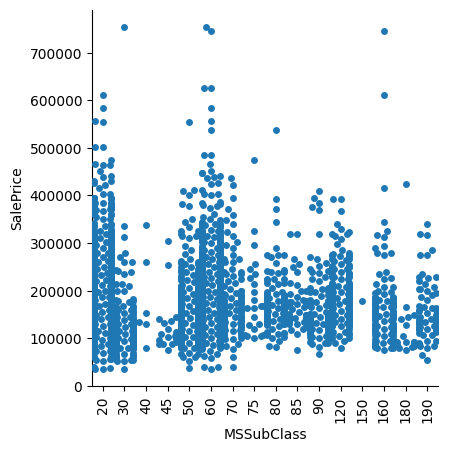

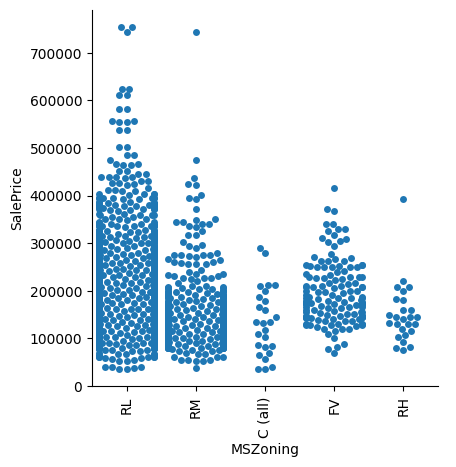

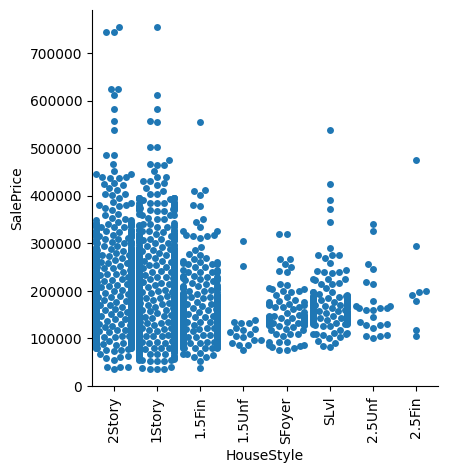

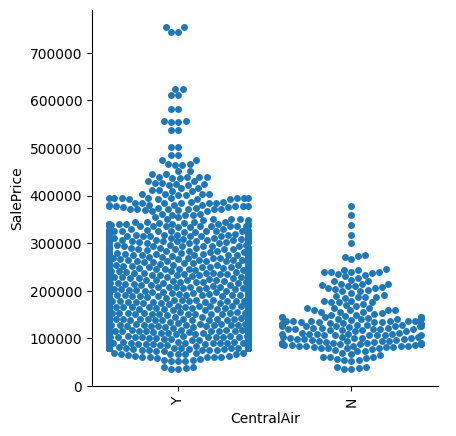

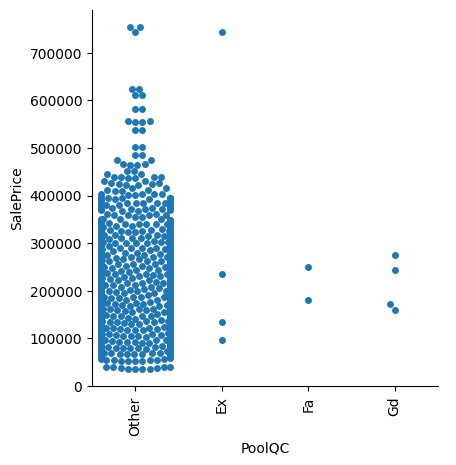

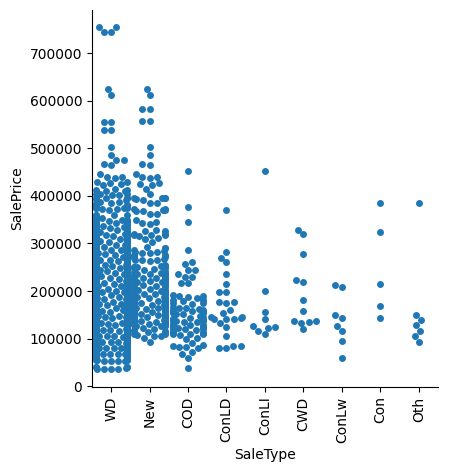

In [9]:
# Plotting SalePrice against some notable categorical variables
# for col in ["MSSubClass", "MSZoning", "HouseStyle","CentralAir", "PoolQC", "SaleType"]:
#     cat_plot = sns.catplot(y="SalePrice", x=col, kind="swarm", legend="full", data=combined, height=4.5, aspect=3 / 3,);
#     cat_plot.set_xticklabels(rotation=90)

In [10]:
# One-hot encoding
combined = pd.get_dummies(combined)